<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/JuhongPark/snu-fintech-ai/blob/main/Lending_Club_SSAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 데이터 가져오기 및 전처리

In [1]:
# Brnach 지정
branch = 'develop'

# 라이브러리 설치 (2분 가량 소요됨)
#!pip install shap -q
#!pip install pytorch_tabnet -q

# 필요 파일 다운로드
#!wget https://raw.githubusercontent.com/JuhongPark/snu-fintech-ai/{branch}/LC_Data_Cleaned_0829.csv

In [2]:
seed = 42  # seed 값 설정
is_test = False  # 테스트런 설정

# 입력 변수 파라미터
target = 'loan_status_encoded'
drop_list = ['id', 'int_rate', 'installment', 'sub_grade', 'grade', 'tbond_int', 'year', 'term', 'loan_status', 'zip_code']
feature_list = ['loan_amnt', 'emp_length', 'revol_util', 'pub_rec', 'fico_range_high', 'fico_range_low', 'percent_bc_gt_75', 'annual_inc',
                'dti', 'delinq_2yrs', 'open_acc', 'revol_bal', 'total_acc', 'inq_last_6mths'] # 'fico_range_low'제외
cat_list = ['purpose', 'addr_state', 'initial_list_status', 'home_ownership', 'application_type', 'verification_status_joint', 'issue_d']

# 대출 이후 변수
post_list = ['Funded_amnt', 'funded_amnt_inv', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d',
 'mths_since_last_major_derog', 'next_pymnt_d', 'out_prncp', 'out_prncp_inv', 'recoveries', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
 'total_rec_prncp', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date',
 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount', 'debt_settlement_flag', 'last_fico_range_high', 'last_fico_range_low']

# 모델 파라미터 설정
# For model
learning_rate = 0.01

# For training
#n_epochs = 10000

# For CV
cv = 10

# For SSAE
n_epochs_ssae = 10000
latent_size = 8

# 테스트 런일 경우, 에포크 수를 줄임
if is_test:
    n_epochs = 10

In [3]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
from sklearn.ensemble import RandomForestClassifier
#from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgbm
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
# Random Seed 설정
def set_random_seed(seed):
    random.seed(seed) # 파이썬 표준 라이브러리
    np.random.seed(seed) # numpy의 random 모듈에서 사용하는 seed
    torch.manual_seed(seed) # pytorch에서 사용하는 seed
    if torch.cuda.is_available(): # GPU에서 실행되는 PyTorch 연산의 무작위성을 제어
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# seed 값 설정
set_random_seed(seed)

## 데이터 다운로드하기

In [5]:
# 모든 행이 화면에 표시되도록 설정합니다.
pd.set_option('display.max_rows', None)

# 파일 로드
file_path = 'LC_Data_Cleaned_0829.csv'
df = pd.read_csv(file_path)

# 테스트 런일 경우, 데이터 크기 줄이기
if is_test:
    df = df.sample(frac=0.01, random_state=seed)

## 데이터 구조 훑어 보기

In [6]:
df.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_status_encoded,year,tbond_int
0,1000.0,1000.0,0,0.1824,36.28,D,D5,10.0,1,70000.0,...,100.0,0.0,1.0,82804.0,61559.0,22800.0,51304.0,0,2014,0.001211
1,5000.0,5000.0,0,0.1199,166.05,B,B3,10.0,0,37000.0,...,80.0,0.0,0.0,55620.0,18537.0,8000.0,12955.0,0,2014,0.001211
2,22975.0,22975.0,1,0.1015,489.85,B,B2,7.0,0,81000.0,...,75.0,0.0,0.0,203958.0,72241.0,21200.0,79120.0,0,2014,0.016416
3,14825.0,14825.0,1,0.1855,380.91,D,D2,10.0,1,37000.0,...,40.0,0.0,0.0,63937.0,26644.0,15300.0,34437.0,1,2013,0.011721
4,10000.0,10000.0,0,0.0762,311.62,A,A3,10.0,0,85000.0,...,25.0,0.0,0.0,350965.0,107907.0,47797.0,100380.0,1,2013,0.001312


## 데이터 전처리

In [7]:
# 기존 df 에 있는 칼럼 중에서, drop_list 및 post_list의 칼럼 제거
drop_list = list(set(df.columns) & set(drop_list + post_list))

# 불필요한 변수 Drop
df = df.drop(columns = drop_list)

# 결측치 처리
df = df.fillna(0)
df.shape

(222028, 59)

In [8]:
X = df.drop(columns=[target])
y = df[target]

# 모델 선택과 훈련

## 테스트 세트 만들기

In [9]:
# Torch 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if not is_test else "cpu" 

In [10]:
# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 언더샘플링 객체 생성
print(f"Original y_train distribution: {y_train.value_counts()}")
print(len(X_train), len(X_test), len(y_train), len(y_test))

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()

# 트레인 데이터셋에 대해 언더샘플링 수행
X_train, y_train = rus.fit_resample(X_train, y_train)

# 결과 확인
print(f"Resampled y_train distribution: {y_train.value_counts()}")
print(len(X_train), len(X_test), len(y_train), len(y_test))

Original y_train distribution: loan_status_encoded
0    147586
1     30036
Name: count, dtype: int64
177622 44406 177622 44406
Resampled y_train distribution: loan_status_encoded
0    30036
1    30036
Name: count, dtype: int64
60072 44406 60072 44406


In [11]:
# 수치형 변수 선정
num_list = list(set(X_train.columns) ^ set(cat_list))

In [12]:
# OneHotEncoder 생성 및 학습 데이터에 적합
from sklearn.preprocessing import OneHotEncoder
oneHotEncoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oneHotEncoder.fit(X_train[cat_list])

# 학습 데이터에 인코딩 적용
X_train_encoded = pd.DataFrame(
    oneHotEncoder.transform(X_train[cat_list]), 
    columns=oneHotEncoder.get_feature_names_out(cat_list), 
    index=X_train.index
)

# 테스트 데이터에 인코딩 적용
X_test_encoded = pd.DataFrame(
    oneHotEncoder.transform(X_test[cat_list]), 
    columns=oneHotEncoder.get_feature_names_out(cat_list), 
    index=X_test.index
)

# 원래 데이터프레임과 병합
X_train = X_train.drop(cat_list, axis=1).join(X_train_encoded)
X_test = X_test.drop(cat_list, axis=1).join(X_test_encoded)

In [13]:
# 표준화 (훈련 데이터에 fit_transform, 테스트 데이터에 transform)
scaler = StandardScaler()

# 수치형 변수 찾기
X_train[num_list] = scaler.fit_transform(X_train[num_list])  # (TODO): 더미 변수 표준화에서 제외해야함
X_test[num_list] = scaler.transform(X_test[num_list])

In [14]:
print(X_train.shape)
print(y_train.shape)

(60072, 119)
(60072,)


## SSAE 모델 정의

In [15]:
# SSAE 모델 정의
class DenoisingSSAE(nn.Module):
    def __init__(self, input_dim):
        super(DenoisingSSAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),  # input_dim이 실제 데이터의 feature 수와 일치해야 함
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)  # output_dim도 input_dim과 일치해야 함
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Noise 추가 함수
def add_noise(data, noise_factor=0.2):
    noise = noise_factor * np.random.randn(*data.shape)
    noisy_data = data + noise
    noisy_data = np.clip(noisy_data, 0., 1.)
    return noisy_data

In [16]:
# Encoding 목표 설정
encoding_target = list(set(X_train.columns) ^ set(feature_list))

# 노이즈가 추가
X_train_noisy_np = add_noise(X_train[encoding_target]).to_numpy()
X_train_np = X_train[encoding_target].to_numpy()
          
input_dim = X_train_np.shape[1]  # X_train의 feature 수
print(input_dim)

105


In [17]:
# 모델 생성 및 학습 설정
ssae_model = DenoisingSSAE(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ssae_model.parameters(), lr=learning_rate)

# 모델 학습
for epoch in range(n_epochs_ssae):
    ssae_model.train()
    inputs = torch.FloatTensor(X_train_noisy_np).to(device)  # NumPy 배열 -> PyTorch 텐서
    targets = torch.FloatTensor(X_train_np).to(device)  # NumPy 배열 -> PyTorch 텐서

    # Forward pass
    outputs = ssae_model(inputs)
    loss = criterion(outputs, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{n_epochs_ssae}], Loss: {loss.item():.4f}')

Epoch [1/10000], Loss: 0.4314
Epoch [10/10000], Loss: 0.3744
Epoch [20/10000], Loss: 0.3456
Epoch [30/10000], Loss: 0.3189
Epoch [40/10000], Loss: 0.3069
Epoch [50/10000], Loss: 0.2979
Epoch [60/10000], Loss: 0.2796
Epoch [70/10000], Loss: 0.2762
Epoch [80/10000], Loss: 0.2678
Epoch [90/10000], Loss: 0.2612
Epoch [100/10000], Loss: 0.2579
Epoch [110/10000], Loss: 0.2530
Epoch [120/10000], Loss: 0.2451
Epoch [130/10000], Loss: 0.2404
Epoch [140/10000], Loss: 0.2363
Epoch [150/10000], Loss: 0.2327
Epoch [160/10000], Loss: 0.2321
Epoch [170/10000], Loss: 0.2283
Epoch [180/10000], Loss: 0.2263
Epoch [190/10000], Loss: 0.2267
Epoch [200/10000], Loss: 0.2227
Epoch [210/10000], Loss: 0.2210
Epoch [220/10000], Loss: 0.2195
Epoch [230/10000], Loss: 0.2208
Epoch [240/10000], Loss: 0.2163
Epoch [250/10000], Loss: 0.2146
Epoch [260/10000], Loss: 0.2137
Epoch [270/10000], Loss: 0.2086
Epoch [280/10000], Loss: 0.2162
Epoch [290/10000], Loss: 0.2066
Epoch [300/10000], Loss: 0.2047
Epoch [310/10000], 

## 모델 평가함수 및 실행

In [18]:
# 평가함수 정의
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
        
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [19]:
# Shapley Value 계산, 시각화 함수 정의
def evaluate_models_shap1(model, X_train_encoded_ssae, X_test_encoded_ssae):
    masker = shap.maskers.Independent(X_train_encoded_ssae)
    explainer = shap.LinearExplainer(model, masker=masker)
    shap_values = explainer(X_test_encoded_ssae)

    # summary_plot을 사용한 Shapley Value 시각화
    shap.summary_plot(shap_values, X_test_encoded_ssae, feature_names=[f"Encoded_{i}" for i in range(X_test_encoded_ssae.shape[1])])

def evaluate_models_shap2(model, X_test_encoded_ssae):
    # TreeExplainer를 사용한 Shapley Value 계산
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_encoded_ssae)

    # summary_plot을 사용한 Shapley Value 시각화
    shap.summary_plot(shap_values, X_test_encoded_ssae, feature_names=[f"Encoded_{i}" for i in range(X_test_encoded_ssae.shape[1])])


In [20]:
# ShapleyValue 계산, 시각화함수 정의 (TabNet 전용)
def evaluate_models_shap_tabnet(model, X_train_encoded_ssae, X_test_encoded_ssae):
    # DeepExplainer를 사용한 Shapley Value 계산 (TabNet 전용)
    explainer = DeepExplainer(model, X_train_encoded_ssae)
    shap_values = explainer.shap_values(X_test_encoded_ssae)

    # summary_plot을 사용한 Shapley Value 시각화
    shap.summary_plot(shap_values, X_test_encoded_ssae, feature_names=[f"Encoded_{i}" for i in range(X_test_encoded_ssae.shape[1])])

In [21]:
# 교차 검증(CV)을 위한 함수 정의
def cross_validate_model(model, X, y, cv=cv):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"Cross-validation scores: {scores}")

In [22]:
encoded_list = [f'e{i}' for i in range(latent_size)]
X_train_encoded = pd.concat(
                    [X_train[feature_list],
                    pd.DataFrame(ssae_model.encoder(torch.FloatTensor(X_train[encoding_target].to_numpy()).to(device)).detach().numpy(),
                                 index=X_train.index, columns=encoded_list)],
                    axis=1)

X_test_encoded = pd.concat(
                    [X_test[feature_list],
                    pd.DataFrame(ssae_model.encoder(torch.FloatTensor(X_test[encoding_target].to_numpy()).to(device)).detach().numpy(),
                                 index=X_test.index, columns=encoded_list)],
                    axis=1)

In [23]:
# 표준화 (훈련 데이터에 fit_transform, 테스트 데이터에 transform)
scalerenc = StandardScaler()
X_train_encoded[encoded_list] = scalerenc.fit_transform(X_train_encoded[encoded_list])
X_test_encoded[encoded_list] = scalerenc.transform(X_test_encoded[encoded_list])


Best Logistic Regression model:
  F1 Score: 0.3391
  Accuracy: 0.5811
  Precision: 0.2313
  Recall: 0.6355
  Best Parameters: {'C': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


Best XGBoost model:
  F1 Score: 0.3459
  Accuracy: 0.5959
  Precision: 0.2382
  Recall: 0.6319
  Best Parameters: {'learning_rate': 0.01, 'n_estimators': 1000, 'reg_alpha': 0.001, 'reg_lambda': 10.0}


Best LightGBM model:
  F1 Score: 0.3466
  Accuracy: 0.5955
  Precision: 0.2385
  Recall: 0.6346
  Best Parameters: {'learning_rate': 0.01, 'n_estimators': 1000, 'reg_alpha': 0.1, 'reg_lambda': 0.001}


Best RandomForest model:
  F1 Score: 0.3412
  Accuracy: 0.5828
  Precision: 0.2328
  Recall: 0.6388
  Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


Best SVM model:
  F1 Score: 0.2722
  Accuracy: 0.4889
  Precision: 0.1793
  Recall: 0.5652
  Best Parameters: {'C': 0.001, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 1000

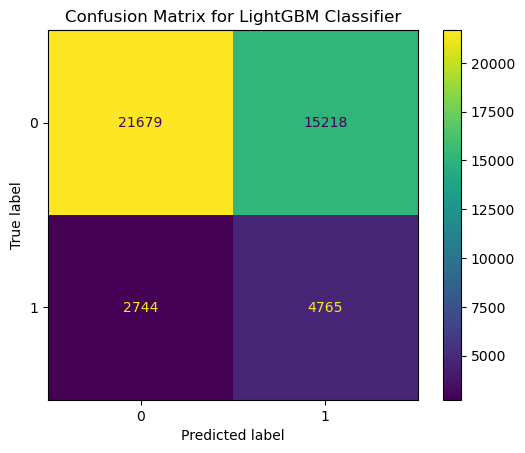

In [36]:
import warnings
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import numpy as np
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Train and evaluate the model with a given parameter set
def evaluate_model(model_name, model, param_set):
    try:
        model.set_params(**param_set)
        model.fit(X_train_encoded.drop(encoded_list, axis=1), y_train)

        y_pred = model.predict(X_test_encoded.drop(encoded_list, axis=1))

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        return accuracy, precision, recall, f1, confusion_matrix(y_test, y_pred)
    except Exception as e:
        print(f"Error evaluating {model_name} with params: {param_set}. Error: {str(e)}")
        return None, None, None, None, None

# Define parameter grids for each model
logistic_param_grid = {
    'C': np.logspace(-3, 3, 3),  # Regularization strength with 10 values
    'penalty': ['l2'],
    'solver': ['lbfgs'],  # Fast solver for logistic regression with L2 regularization
    'max_iter': [1000]  # Very high iteration count
}

xgb_param_grid = {
    'learning_rate': np.logspace(-4, 0, 3),
    'reg_alpha': np.logspace(-3, 1, 3),
    'reg_lambda': np.logspace(-3, 1, 3),
    'n_estimators': [1000]
}

lgb_param_grid = {
    'learning_rate': np.logspace(-4, 0, 3),
    'reg_alpha': np.logspace(-3, 1, 3),
    'reg_lambda': np.logspace(-3, 1, 3),
    'n_estimators': [1000]
}

rf_param_grid = {
    'n_estimators': [1000],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

svm_param_grid = {
    'C': np.logspace(-3, 3, 3),  # Regularization strength with 10 values
    'kernel': ['rbf'],  # RBF kernel is commonly used
    'gamma': ['scale'],  # Standard option for gamma
    'max_iter': [1000]  # Very high iteration count for convergence
}

# Evaluate models with parameter grids
logistic_model = LogisticRegression(n_jobs=-1)
xgb_model = xgb.XGBClassifier(n_jobs=-1, verbosity=0)  # Disable XGBoost output
lgb_model = lgb.LGBMClassifier(n_jobs=-1, verbose=-1)  # Disable LightGBM output
rf_model = RandomForestClassifier(n_jobs=-1)
svm_model = SVC()

# Dictionary to store best results for each model
best_results = {}

# Logistic Regression with F1 optimization
for params in ParameterGrid(logistic_param_grid):
    accuracy, precision, recall, f1, cm = evaluate_model('Logistic Regression', logistic_model, params)
    if accuracy is not None and ('Logistic Regression' not in best_results or f1 > best_results['Logistic Regression']['f1_score']):
        best_results['Logistic Regression'] = {
            'model': logistic_model,
            'params': params,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm
        }

print(f"\nBest Logistic Regression model:")
if 'Logistic Regression' in best_results:
    print(f"  F1 Score: {best_results['Logistic Regression']['f1_score']:.4f}")
    print(f"  Accuracy: {best_results['Logistic Regression']['accuracy']:.4f}")
    print(f"  Precision: {best_results['Logistic Regression']['precision']:.4f}")
    print(f"  Recall: {best_results['Logistic Regression']['recall']:.4f}")
    print(f"  Best Parameters: {best_results['Logistic Regression']['params']}\n")

# XGBoost with F1 optimization
for params in ParameterGrid(xgb_param_grid):
    accuracy, precision, recall, f1, cm = evaluate_model('XGBoost Classifier', xgb_model, params)
    if accuracy is not None and ('XGBoost Classifier' not in best_results or f1 > best_results['XGBoost Classifier']['f1_score']):
        best_results['XGBoost Classifier'] = {
            'model': xgb_model,
            'params': params,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm
        }

print(f"\nBest XGBoost model:")
if 'XGBoost Classifier' in best_results:
    print(f"  F1 Score: {best_results['XGBoost Classifier']['f1_score']:.4f}")
    print(f"  Accuracy: {best_results['XGBoost Classifier']['accuracy']:.4f}")
    print(f"  Precision: {best_results['XGBoost Classifier']['precision']:.4f}")
    print(f"  Recall: {best_results['XGBoost Classifier']['recall']:.4f}")
    print(f"  Best Parameters: {best_results['XGBoost Classifier']['params']}\n")

# LightGBM with F1 optimization
for params in ParameterGrid(lgb_param_grid):
    accuracy, precision, recall, f1, cm = evaluate_model('LightGBM Classifier', lgb_model, params)
    if accuracy is not None and ('LightGBM Classifier' not in best_results or f1 > best_results['LightGBM Classifier']['f1_score']):
        best_results['LightGBM Classifier'] = {
            'model': lgb_model,
            'params': params,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm
        }

print(f"\nBest LightGBM model:")
if 'LightGBM Classifier' in best_results:
    print(f"  F1 Score: {best_results['LightGBM Classifier']['f1_score']:.4f}")
    print(f"  Accuracy: {best_results['LightGBM Classifier']['accuracy']:.4f}")
    print(f"  Precision: {best_results['LightGBM Classifier']['precision']:.4f}")
    print(f"  Recall: {best_results['LightGBM Classifier']['recall']:.4f}")
    print(f"  Best Parameters: {best_results['LightGBM Classifier']['params']}\n")

# RandomForest with F1 optimization
for params in ParameterGrid(rf_param_grid):
    accuracy, precision, recall, f1, cm = evaluate_model('RandomForest Classifier', rf_model, params)
    if accuracy is not None and ('RandomForest Classifier' not in best_results or f1 > best_results['RandomForest Classifier']['f1_score']):
        best_results['RandomForest Classifier'] = {
            'model': rf_model,
            'params': params,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm
        }

print(f"\nBest RandomForest model:")
if 'RandomForest Classifier' in best_results:
    print(f"  F1 Score: {best_results['RandomForest Classifier']['f1_score']:.4f}")
    print(f"  Accuracy: {best_results['RandomForest Classifier']['accuracy']:.4f}")
    print(f"  Precision: {best_results['RandomForest Classifier']['precision']:.4f}")
    print(f"  Recall: {best_results['RandomForest Classifier']['recall']:.4f}")
    print(f"  Best Parameters: {best_results['RandomForest Classifier']['params']}\n")

# SVM with F1 optimization
for params in ParameterGrid(svm_param_grid):
    accuracy, precision, recall, f1, cm = evaluate_model('SVM Classifier', svm_model, params)
    if accuracy is not None and ('SVM Classifier' not in best_results or f1 > best_results['SVM Classifier']['f1_score']):
        best_results['SVM Classifier'] = {
            'model': svm_model,
            'params': params,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm
        }

print(f"\nBest SVM model:")
if 'SVM Classifier' in best_results:
    print(f"  F1 Score: {best_results['SVM Classifier']['f1_score']:.4f}")
    print(f"  Accuracy: {best_results['SVM Classifier']['accuracy']:.4f}")
    print(f"  Precision: {best_results['SVM Classifier']['precision']:.4f}")
    print(f"  Recall: {best_results['SVM Classifier']['recall']:.4f}")
    print(f"  Best Parameters: {best_results['SVM Classifier']['params']}\n")

# Find the best overall model based on F1 score
best_model_name = max(best_results, key=lambda x: best_results[x]['f1_score'])
best_model_results = best_results[best_model_name]

# Print the best overall model
print(f"\nBest overall model: {best_model_name}")
print(f"  F1 Score: {best_model_results['f1_score']:.4f}")
print(f"  Accuracy: {best_model_results['accuracy']:.4f}")
print(f"  Precision: {best_model_results['precision']:.4f}")
print(f"  Recall: {best_model_results['recall']:.4f}")
print(f"  Best Parameters: {best_model_results['params']}")

# Plot confusion matrix for the best overall model
disp = ConfusionMatrixDisplay(confusion_matrix=best_model_results['confusion_matrix'])
disp.plot()
plt.title(f"Confusion Matrix for {best_model_name}")
plt.show()

# SHAP 내용 추가

In [ ]:
# SHAP
class ClsModel:
    def __init__(self, reg_model, ssae_model, feature_list, encoding_target, reg_columns, device='cpu'):
        self.reg_model = reg_model
        self.ssae_model = ssae_model
        self.feature_list = feature_list
        self.encoding_target = encoding_target
        self.reg_columns = reg_columns
        self.device = device

    def predict(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns = self.reg_columns)
        
        X_org = X[self.feature_list]
        X_encoded = X[self.encoding_target]
        X_encoded = pd.DataFrame(self.ssae_model.encoder(torch.FloatTensor(X_encoded.to_numpy()).to(device)).detach().numpy(),
                        index=X_encoded.index, columns=[f'e{i}' for i in range(latent_size)])
        X_con = pd.concat([X_org, X_encoded], axis=1)
        
        return self.reg_model.predict(X_con)

    def __call__(self, X):
        return self.predict(X)

cls_model = ClsModel(best_lgb_model, ssae_model, feature_list, encoding_target, X_test.columns)  # 첫번째 모델 변경 필요, 원본 X_test로 계산해야함
explainer = shap.KernelExplainer(cls_model, X_test[0:30])
shap_values = explainer.shap_values(X_test[0:30])
shap.summary_plot(shap_values, X_test[0:30])